In [3]:
import scipy.io
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from skimage.filters import threshold_multiotsu

In [4]:

# Load the .mat file
mat = scipy.io.loadmat('Indian_pines.mat')

# Extract the image data (replace 'indian_pines' with the correct key if different)
image_data = mat['indian_pines']

# Reshape the data to 2D (pixels x bands) for PCA
pixels, bands = image_data.shape[0] * image_data.shape[1], image_data.shape[2]
image_data_reshaped = image_data.reshape(pixels, bands)

# Apply PCA to reduce to 1 component
pca = PCA(n_components=1)
image_data_pca = pca.fit_transform(image_data_reshaped)

# Reshape back to 2D (original spatial dimensions)
image_data_pca_reshaped = image_data_pca.reshape(image_data.shape[0], image_data.shape[1])

# Normalize the data to fit into the 8-bit range (0-255)
image_data_normalized = (255 * (image_data_pca_reshaped - np.min(image_data_pca_reshaped)) / 
                         (np.max(image_data_pca_reshaped) - np.min(image_data_pca_reshaped))).astype(np.uint8)

# Convert to PIL Image
image = Image.fromarray(image_data_normalized)


In [7]:
print(f"Image min: {np.min(image_data_normalized)}, max: {np.max(image_data_normalized)}")

Image min: 0, max: 255


In [9]:

def patch_based_multiotsu(image, patch_size):
    height, width = image.shape[:2]
    segmented = np.zeros_like(image)
    
    for y in range(0, height - patch_size, patch_size):
        for x in range(0, width - patch_size, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            try:
                # Increase number of bins and add error handling
                print(f"Processing patch at ({x}, {y}) with shape {patch.shape}")
                thresholds = threshold_multiotsu(patch, nbins=256, classes=5)#min(optimal_cluster_number, 5))
                regions = np.digitize(patch, bins=thresholds)
                segmented[y:y+patch_size, x:x+patch_size] = regions * 85
            except ValueError:
                # If multi-otsu fails, fall back to simple thresholding
                print(f"Multi-Otsu failed for patch at ({x}, {y}), using simple thresholding.")
                threshold = np.mean(patch)
                segmented[y:y+patch_size, x:x+patch_size] = (patch > threshold) * 170
    
    return segmented

patches = patch_based_multiotsu(image_data_normalized, 145)
patches


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
#print(f"Processing patch at ({x}, {y}) with shape {patch.shape}")
thresholds = threshold_multiotsu(image_data_normalized, nbins=256, classes=6)#min(optimal_cluster_number, 5))
regions = np.digitize(image_data_normalized, bins=thresholds)
# segmented[y:y+patch_size, x:x+patch_size] = regions * 85

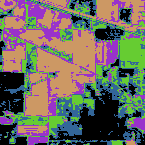

In [8]:
regions
# Convert the segmented image to a PIL Image with different colors for each region
segmented_image = np.zeros((image_data_normalized.shape[0], image_data_normalized.shape[1], 3), dtype=np.uint8)
for i in range(5):
    segmented_image[regions == i] = np.array([i * 51, i * 102, i * 153])  # Different colors for each region
segmented_image_pil = Image.fromarray(segmented_image)
segmented_image_pil.show()